### Librerías

In [3]:
!pip install --upgrade --no-cache-dir gdown
!pip install torchmetrics
!pip install torcheval

import os

import random
import numpy as np
import pandas as pd


import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18, ResNet18_Weights, resnet50, ResNet50_Weights

from torchmetrics.classification import MulticlassAccuracy
from torcheval.metrics.functional import multiclass_confusion_matrix

from matplotlib import pyplot as plt

### Cargar imágenes y sus targets

In [4]:
# Descargar y descromprimir el dataset de imágenes de fondo de ojo.
!gdown 1Mcizi0JMfEtZE5dBzOgdOPXlUfMUCCAS
!unzip /kaggle/working/preprocessed_images.zip -d ./preprocessed_images

# Descargar .csv que contiene los targets para cada imagen.
!gdown 1xe5Qzvqjzwlspm24um4sfnvY1RwL6c2h

Downloading...
From (original): https://drive.google.com/uc?id=1Mcizi0JMfEtZE5dBzOgdOPXlUfMUCCAS
From (redirected): https://drive.google.com/uc?id=1Mcizi0JMfEtZE5dBzOgdOPXlUfMUCCAS&confirm=t&uuid=242fb482-c060-4856-90d6-594ca1525aed
To: /kaggle/working/preprocessed_images.zip
100%|████████████████████████████████████████| 394M/394M [00:04<00:00, 88.0MB/s]
Archive:  /kaggle/working/preprocessed_images.zip
  inflating: ./preprocessed_images/preprocessed_images/0_left.jpg  
  inflating: ./preprocessed_images/preprocessed_images/0_right.jpg  
  inflating: ./preprocessed_images/preprocessed_images/1_left.jpg  
  inflating: ./preprocessed_images/preprocessed_images/1_right.jpg  
  inflating: ./preprocessed_images/preprocessed_images/10_left.jpg  
  inflating: ./preprocessed_images/preprocessed_images/10_right.jpg  
  inflating: ./preprocessed_images/preprocessed_images/100_left.jpg  
  inflating: ./preprocessed_images/preprocessed_images/100_right.jpg  
  inflating: ./preprocessed_images/pre

### Instanciar dataset y dataloaders

In [5]:
class FundusDataset(Dataset):
    '''
    Custom Dataset para la carga de las imágenes de fondo de ojo con sus respectivos targets.
    Targets y sus significados:
    0 - Normal
    1 - Diabetes
    2 - Glaucoma
    3 - Cataratas
    4 - Degeneración macular asociada a la edad
    5 - Hipertensión
    6 - Miopía
    7 - Otras enfermedades o anormalidades
    '''
    def __init__(self, images_path, targets_df, transform=None):
        self.image_folder = ImageFolder(root=images_path, transform=transform)
        self.targets_df = targets_df

    def __len__(self):
        return len(self.image_folder)

    def __getitem__(self, idx):
        img, _ = self.image_folder[idx]
        img_filename = os.path.basename(self.image_folder.imgs[idx][0])
        target = np.array(self._map_label_to_target(self.targets_df.loc[self.targets_df['filename'] == img_filename, 'labels'].values[0]))
        return img, target

    def _map_label_to_target(self, label):
        if label == '[\'N\']':
            return 0
            #return [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        elif label == '[\'D\']':
            return 1
            #return [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        elif label == '[\'G\']':
            return 2
            #return [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        elif label == '[\'C\']':
            return 3
            #return [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
        elif label == '[\'A\']':
            return 4
            #return [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
        elif label == '[\'H\']':
            return 5
            #return [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
        elif label == '[\'M\']':
            return 6
            #return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
        elif label == '[\'O\']':
            return 7
            #return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
        else:
            raise Exception('Target desconocido')

class TransformedDataset(Dataset):
    def __init__(self, original_dataset, transform):
        self.original_dataset = original_dataset
        self.transform = transform

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        image, label = self.original_dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Leer el dataframe que contiene los targets para cada imagen.
full_df = pd.read_csv('full_df.csv')

# Instanciar el dataset.
dataset = FundusDataset(
    images_path='./preprocessed_images',
    targets_df=full_df)

# Dividir el dataset en entrenamiento y testing.
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
train_dataset = TransformedDataset(train_dataset, transform=data_transforms)
test_dataset = TransformedDataset(test_dataset, transform=data_transforms)

# Instanciar dataloaders para ambos subsets.
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Verificar shapes de los batches de entrenamiento.
train_features, train_labels = next(iter(train_dataloader))
print(f'Train feature batch shape: {train_features.size()}')
print(f'Train labels batch shape: {train_labels.size()}')

# Verificar shapes de los batches de testing.
test_features, test_labels = next(iter(test_dataloader))
print(f'Test feature batch shape: {test_features.size()}')
print(f'Test labels batch shape: {test_labels.size()}')

Train feature batch shape: torch.Size([32, 3, 224, 224])
Train labels batch shape: torch.Size([32])
Test feature batch shape: torch.Size([32, 3, 224, 224])
Test labels batch shape: torch.Size([32])


### Graficar una imagen de cada clase

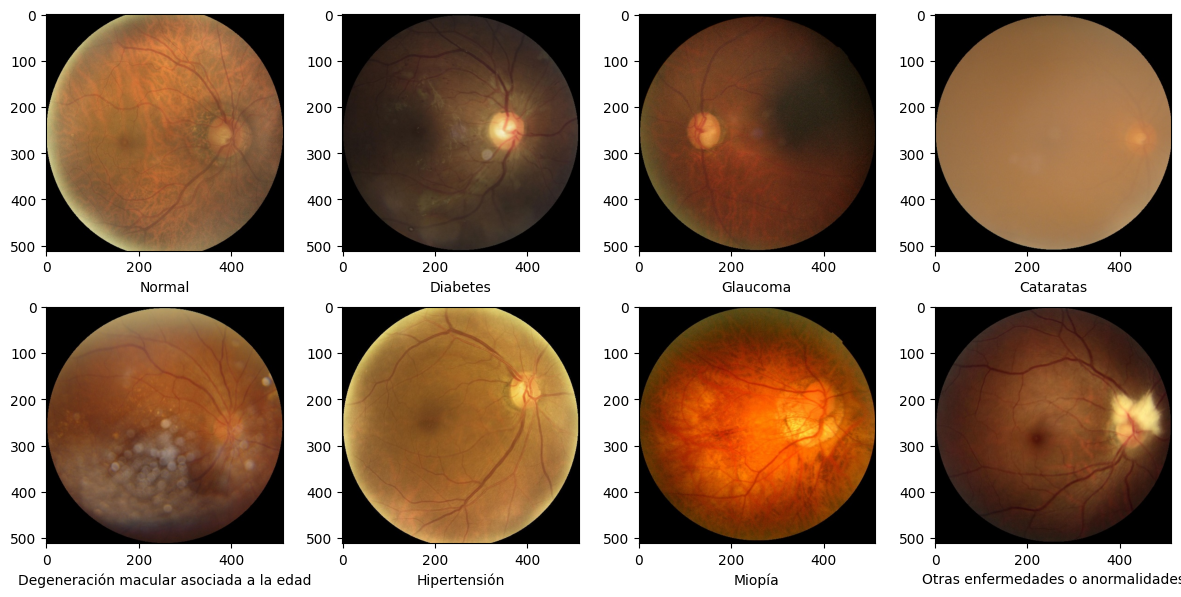

In [6]:
def get_samples_by_label(dataset, target_label):
    filtered_indices = [
        i for i, (data, label) in enumerate(dataset) if np.array_equal(label, target_label)
    ]
    return filtered_indices

def get_random_sample_by_label(dataset, target_label):
    filtered_indices = get_samples_by_label(dataset, target_label)
    random_index = random.choice(filtered_indices)
    return dataset[random_index]

def map_target_to_label(y):
    if y == 0:
        return 'Normal'
    elif y == 1:
        return 'Diabetes'
    elif y == 2:
        return 'Glaucoma'
    elif y == 3:
        return 'Cataratas'
    elif y == 4:
        return 'Degeneración macular asociada a la edad'
    elif y == 5:
        return 'Hipertensión'
    elif y == 6:
        return 'Miopía'
    elif y == 7:
        return 'Otras enfermedades o anormalidades'
    else:
        raise Exception('Target desconocido')

raw_dataset = FundusDataset(
    images_path='./preprocessed_images',
    targets_df=full_df,
    transform=transforms.Compose([transforms.ToTensor()]))

raw_dataset = Subset(raw_dataset, range(300))

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
idx = 0
for i in range(2):
    for j in range(4):
        target_label = float(idx)
        idx += 1
        img, label = get_random_sample_by_label(raw_dataset, target_label)
        ax[i][j].set_xlabel(map_target_to_label(target_label))
        ax[i][j].imshow(img.permute(1, 2, 0))
plt.tight_layout()
plt.show()

### Mostrar dataframe y cantidad de casos para cada clase

In [7]:
full_df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


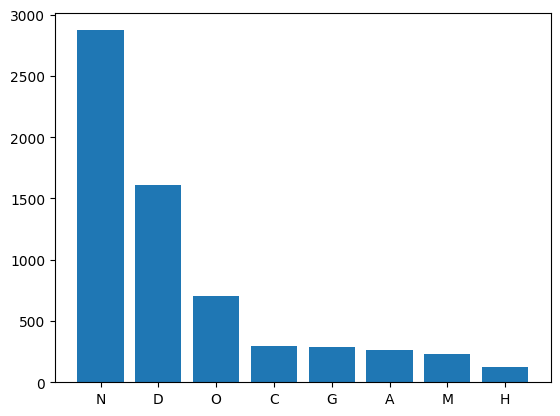

N: 2873
D: 1608
O: 708
C: 293
G: 284
A: 266
M: 232
H: 128


In [8]:
# Mostrar cantidad de casos para cada clase.

def clean_label(label):
    for c in ['[', ']', '\'']:
        label = str.replace(label, c, '')
    return label

labels_counts = full_df['labels'].value_counts()

plt.bar(
    labels_counts.keys().map(clean_label),
    labels_counts.values)

plt.show()

for k, v in labels_counts.items():
    print(f'{clean_label(k)}: {v}')

### Funciones de entrenamiento, de métrica, de gráfica y de impresión de resultados

In [9]:
def fit(nnet,
        train_dataloader,
        valid_dataloader,
        optimizer,
        loss_function,
        epochs,
        device,
        num_targets,
        early_stop_tol=None,
        scheduler=None,
        verbose=False):

    train_loss_by_epoch = []
    train_accuracy_by_epoch = []
    valid_loss_by_epoch = []
    valid_accuracy_by_epoch = []

    best_valid_loss = float('inf')
    best_valid_accuracy = 0.0
    epochs_no_improve = 0

    accuracy = MulticlassAccuracy(num_classes=num_targets).to(device)

    for epoch in range(epochs):
        ############################################
        ## Entrenamiento
        ############################################
        nnet.train()

        epoch_loss = 0.0
        epoch_accuracy = 0.0

        for x_batch, y_batch in train_dataloader:
            x_batch = x_batch.to(device).float()
            y_batch = y_batch.to(device)

            # Forward
            optimizer.zero_grad()
            y_batch_hat = nnet(x_batch)

            # Loss
            loss = loss_function(y_batch_hat, y_batch)

            # Backpropagation
            loss.backward()

            # Loss y accuracy en batch
            epoch_loss = epoch_loss + loss.item()
            epoch_accuracy = epoch_accuracy + accuracy(y_batch_hat, y_batch).item()

        if scheduler is None:
            optimizer.step()
        else:
            scheduler.step()

        # Loss y accuracy promedio en epoch
        epoch_loss = epoch_loss / len(train_dataloader)
        epoch_accuracy = epoch_accuracy / len(train_dataloader)
        train_loss_by_epoch.append(epoch_loss)
        train_accuracy_by_epoch.append(epoch_accuracy)

        ############################################
        ## Validación
        ############################################
        nnet.eval()

        valid_epoch_loss = 0.0
        valid_epoch_accuracy = 0.0

        for x_batch, y_batch in valid_dataloader:
            x_batch = x_batch.to(device).float()
            y_batch = y_batch.to(device)

            # Forward
            y_batch_hat = nnet(x_batch)

            # Loss
            loss = loss_function(y_batch_hat, y_batch)

            # Loss y accuracy en batch
            valid_epoch_loss = valid_epoch_loss + loss.item()
            valid_epoch_accuracy = valid_epoch_accuracy + accuracy(y_batch_hat, y_batch).item()

        # Loss y accuracy promedio en epoch
        valid_epoch_loss = valid_epoch_loss / len(valid_dataloader)
        valid_epoch_accuracy = valid_epoch_accuracy / len(valid_dataloader)
        valid_loss_by_epoch.append(valid_epoch_loss)
        valid_accuracy_by_epoch.append(valid_epoch_accuracy)

        # Early stopping.
        if valid_epoch_loss < best_valid_loss:
            best_valid_loss = valid_epoch_loss
            best_valid_accuracy = valid_epoch_accuracy
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        if verbose and epochs_no_improve >= early_stop_tol:
            print(f'Early stopping en época {epoch + 1} con validation loss: {best_valid_loss} y con validation accuracy {best_valid_accuracy}')
            break

        ############################################
        ## Impresión de resultados por epoch
        ############################################
        if verbose and epoch % 5 == 0:
            print(f' Epoch {epoch} | ' \
                f'Train/Valid loss: {epoch_loss:.4f} / {valid_epoch_loss:.4f} | ' \
                f'Train/Valid accuracy: {epoch_accuracy:.4f} / {valid_epoch_accuracy:.4f}')

    return (
        train_loss_by_epoch,
        train_accuracy_by_epoch,
        valid_loss_by_epoch,
        valid_accuracy_by_epoch)

def plot_results(train_loss_by_epoch, valid_loss_by_epoch, train_accuracy_by_epoch, valid_accuracy_by_epoch):
    fig, ax= plt.subplots(1, 2, figsize=(16, 5))
    ax[0].plot(train_loss_by_epoch, label='Train loss')
    ax[0].plot(valid_loss_by_epoch, label='Validation loss')
    ax[0].legend()
    ax[0].set_title('Loss by epoch')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Cross Entropy')

    ax[1].plot(train_accuracy_by_epoch, label='Train accuracy')
    ax[1].plot(valid_accuracy_by_epoch, label='Validation accuracy')
    ax[1].legend()
    ax[1].set_title('Accuracy by epoch')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')

    plt.show()

def print_predictions(model, dataset, num_predictions, device='cpu'):
    predictions_dataloader = DataLoader(test_dataset, batch_size=1)
    model.eval()

    for label in [
        'Normal',
        'Diabetes',
        'Glaucoma',
        'Cataratas',
        'Degeneración macular asociada a la edad',
        'Hipertensión',
        'Miopía', 'Otras enfermedades o anormalidades']:
        print(label, '==================\n')
        idx = 0
        for i, (x, y) in enumerate(predictions_dataloader):
            x = x.to(device).float()
            y = y.to(device)

            target_to_label = map_target_to_label(y)
            if target_to_label != label:
                continue # TODO: Mejorar esta función

            print(f'El valor esperado es \"{target_to_label}\"')
            print(f'El valor obtenido por el modelo es \"{map_target_to_label(torch.argmax(model(x), dim=1))}\"\n')

            if idx == num_predictions:
                break
            idx += 1

### ResNet18. Feature extraction.

#### Instanciar dataset

In [10]:
# Descargar pesos preentrenados de ImageNet y obtener sus transforms.
weights = ResNet18_Weights.DEFAULT
preprocess = weights.transforms(antialias=True)

# Instanciar el dataset.
dataset = FundusDataset(
    images_path='./preprocessed_images',
    targets_df=full_df,
    transform=transforms.Compose([
        transforms.ToTensor(),
        preprocess
    ]))

# Dividir el dataset en entrenamiento y testing.
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Instanciar dataloaders para ambos subsets.
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### Instanciar modelo

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
resnet18_model = resnet18(weights=weights)

# Freezar los parámetros del modelo para realizar transfer learning.
for param in resnet18_model.parameters():
    param.requires_grad = False

# Sobreescribir la capa de salida para adaptar el modelo a un problema de
# clasificación de 8 clases.
num_targets = 8
last_layer_in_features = resnet18_model.fc.in_features
resnet18_model.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features=last_layer_in_features, out_features=num_targets)
)
resnet18_model.to(device)

# Funciones de optimización y de pérdida.
optimizer = torch.optim.Adam(resnet18_model.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss().to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 143MB/s] 


#### Entrenamiento

In [12]:
(train_loss_by_epoch,
 train_accuracy_by_epoch,
 valid_loss_by_epoch,
 valid_accuracy_by_epoch) = fit(
    resnet18_model,
    train_dataloader,
    test_dataloader,
    optimizer,
    loss,
    epochs=100,
    device=device,
    num_targets=num_targets,
    early_stop_tol=5,
    scheduler=None,
    verbose=True)

 Epoch 0 | Train/Valid loss: 1.9974 / 1.7901 | Train/Valid accuracy: 0.1327 / 0.1590
 Epoch 5 | Train/Valid loss: 1.6957 / 1.7388 | Train/Valid accuracy: 0.1614 / 0.1637
Early stopping en época 9 con validation loss: 1.6596781104803084 y con validation accuracy 0.1602338369935751


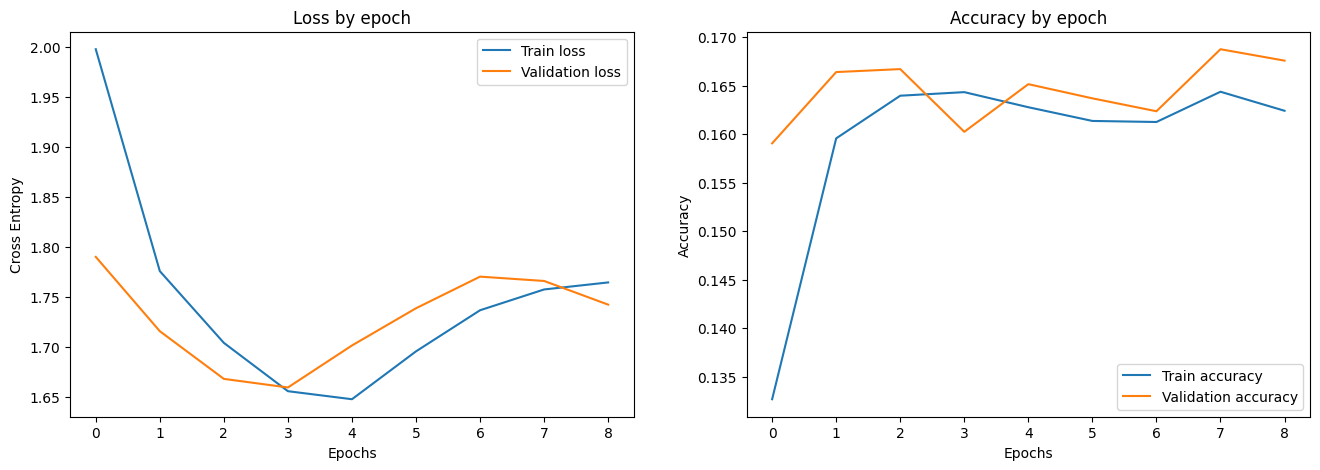

In [13]:
plot_results(
    train_loss_by_epoch,
    valid_loss_by_epoch,
    train_accuracy_by_epoch,
    valid_accuracy_by_epoch)

#### Realizar algunas predicciones

In [14]:
# Se realizan 10 predicciones de cada clase con el modelo y se compara con los
# respectivos valores esperados.
print_predictions(
    resnet18_model,
    test_dataset,
    num_predictions=10,
    device=device)

Normal ==================

El valor esperado es "Normal"
El valor obtenido por el modelo es "Normal"

El valor esperado es "Normal"
El valor obtenido por el modelo es "Normal"

El valor esperado es "Normal"
El valor obtenido por el modelo es "Normal"

El valor esperado es "Normal"
El valor obtenido por el modelo es "Normal"

El valor esperado es "Normal"
El valor obtenido por el modelo es "Normal"

El valor esperado es "Normal"
El valor obtenido por el modelo es "Normal"

El valor esperado es "Normal"
El valor obtenido por el modelo es "Normal"

El valor esperado es "Normal"
El valor obtenido por el modelo es "Normal"

El valor esperado es "Normal"
El valor obtenido por el modelo es "Normal"

El valor esperado es "Normal"
El valor obtenido por el modelo es "Normal"

El valor esperado es "Normal"
El valor obtenido por el modelo es "Normal"

Diabetes ==================

El valor esperado es "Diabetes"
El valor obtenido por el modelo es "Normal"

El valor esperado es "Diabetes"
El valor o

### ResNet18. Fine tuning.

#### Instanciar dataset

In [15]:
# Instanciar el dataset.
dataset = FundusDataset(
    images_path='./preprocessed_images',
    targets_df=full_df,
    transform=transforms.Compose([
        transforms.ToTensor(),
        preprocess
    ]))

# Descargar pesos preentrenados de ImageNet y obtener sus transforms.
weights = ResNet18_Weights.DEFAULT
preprocess = weights.transforms(antialias=True)

# Dividir el dataset en entrenamiento y testing.
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
# train_dataset = TransformedDataset(train_dataset, transform=transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomRotation(degrees=15),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)),
#     transforms.ToTensor(),
#     preprocess
# ]))
# test_dataset = TransformedDataset(test_dataset, transform=transforms.Compose([
#     transforms.ToTensor(),
#     preprocess
# ]))

# Instanciar dataloaders para ambos subsets.
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### Instanciar modelo

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
resnet18_model = resnet18(weights=weights)

for param in resnet18_model.parameters():
    param.requires_grad = True

# Sobreescribir la capa de salida para adaptar el modelo a un problema de
# clasificación de 8 clases.
num_targets = 8
last_layer_in_features = resnet18_model.fc.in_features
resnet18_model.fc = torch.nn.Linear(
    in_features=last_layer_in_features, out_features=num_targets)
resnet18_model.to(device)

# Funciones de optimización y de pérdida.
optimizer = torch.optim.Adam(resnet18_model.parameters(), lr=0.001)
loss = torch.nn.CrossEntropyLoss().to(device)

#### Entrenamiento

In [17]:
(train_loss_by_epoch,
 train_accuracy_by_epoch,
 valid_loss_by_epoch,
 valid_accuracy_by_epoch) = fit(
    resnet18_model,
    train_dataloader,
    test_dataloader,
    optimizer,
    loss,
    epochs=100,
    device=device,
    num_targets=num_targets,
    early_stop_tol=5,
    scheduler=None,
    verbose=True)

 Epoch 0 | Train/Valid loss: 2.3958 / 4.4310 | Train/Valid accuracy: 0.1042 / 0.1508
 Epoch 5 | Train/Valid loss: 1.8553 / 2.1917 | Train/Valid accuracy: 0.1682 / 0.1751
 Epoch 10 | Train/Valid loss: 1.5850 / 1.6615 | Train/Valid accuracy: 0.1799 / 0.1889
 Epoch 15 | Train/Valid loss: 1.4659 / 1.5115 | Train/Valid accuracy: 0.2603 / 0.2884
 Epoch 20 | Train/Valid loss: 1.4132 / 1.3993 | Train/Valid accuracy: 0.3117 / 0.3026
 Epoch 25 | Train/Valid loss: 1.3887 / 1.3885 | Train/Valid accuracy: 0.2732 / 0.2500
 Epoch 30 | Train/Valid loss: 1.4247 / 1.3944 | Train/Valid accuracy: 0.2486 / 0.2595
Early stopping en época 35 con validation loss: 1.3834233701229095 y con validation accuracy 0.27099494617432357


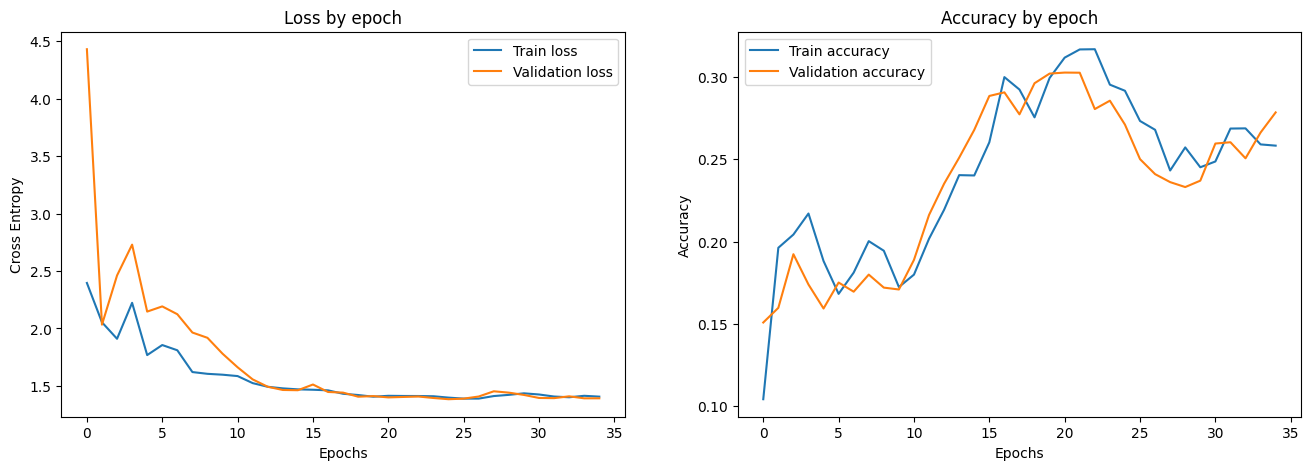

In [18]:
plot_results(
    train_loss_by_epoch,
    valid_loss_by_epoch,
    train_accuracy_by_epoch,
    valid_accuracy_by_epoch)

#### Realizar algunas predicciones

In [19]:
# Se realizan 10 predicciones de cada clase con el modelo y se compara con los
# respectivos valores esperados.
print_predictions(
    resnet18_model,
    test_dataset,
    num_predictions=10,
    device=device)

Normal ==================

El valor esperado es "Normal"
El valor obtenido por el modelo es "Normal"

El valor esperado es "Normal"
El valor obtenido por el modelo es "Normal"

El valor esperado es "Normal"
El valor obtenido por el modelo es "Normal"

El valor esperado es "Normal"
El valor obtenido por el modelo es "Normal"

El valor esperado es "Normal"
El valor obtenido por el modelo es "Normal"

El valor esperado es "Normal"
El valor obtenido por el modelo es "Normal"

El valor esperado es "Normal"
El valor obtenido por el modelo es "Normal"

El valor esperado es "Normal"
El valor obtenido por el modelo es "Normal"

El valor esperado es "Normal"
El valor obtenido por el modelo es "Normal"

El valor esperado es "Normal"
El valor obtenido por el modelo es "Normal"

El valor esperado es "Normal"
El valor obtenido por el modelo es "Normal"

Diabetes ==================

El valor esperado es "Diabetes"
El valor obtenido por el modelo es "Normal"

El valor esperado es "Diabetes"
El valor o

### ResNet50. Feature extraction.

#### Instanciar dataset

In [26]:
# Descargar pesos preentrenados de ImageNet y obtener sus transforms.
weights = ResNet50_Weights.DEFAULT
preprocess = weights.transforms(antialias=True)

# Instanciar el dataset.
dataset = FundusDataset(
    images_path='./preprocessed_images',
    targets_df=full_df,
    transform=transforms.Compose([
    transforms.ToTensor(),
    preprocess
]))

# Dividir el dataset en entrenamiento y testing.
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Instanciar dataloaders para ambos subsets.
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### Instanciar el modelo

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
resnet50_model = resnet50(weights=weights)

# Freezar los parámetros del modelo para realizar transfer learning.
for param in resnet50_model.parameters():
    param.requires_grad = False

# Sobreescribir la capa de salida para adaptar el modelo a un problema de
# clasificación de 8 clases. Agregar dropout para mitigar overfitting.
num_targets = 8
last_layer_in_features = resnet50_model.fc.in_features
# resnet50_model.fc = nn.Sequential(nn.Linear(last_layer_in_features, 2048),
#                                   nn.ReLU(),
#                                   nn.Dropout(p=0.4),
#                                   nn.Linear(2048, 2048),
#                                   nn.ReLU(),
#                                   nn.Dropout(p=0.4),
#                                   nn.Linear(2048, num_targets),
#                                   nn.LogSigmoid())
resnet50_model.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features=last_layer_in_features, out_features=num_targets)
)
resnet50_model.to(device)

# Scheduler, funciones de optimización y de pérdida.
optimizer = torch.optim.Adam(resnet50_model.parameters(), lr=0.001)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
# labels_counts = full_df['labels'].value_counts()
# sample_weights = [
#     1. / labels_counts['[\'N\']'],
#     1. / labels_counts['[\'D\']'],
#     1. / labels_counts['[\'G\']'],
#     1. / labels_counts['[\'C\']'],
#     1. / labels_counts['[\'A\']'],
#     1. / labels_counts['[\'H\']'],
#     1. / labels_counts['[\'M\']'],
#     1. / labels_counts['[\'O\']']
# ]
#loss = torch.nn.CrossEntropyLoss(weight=torch.Tensor(sample_weights)).to(device)
loss = torch.nn.CrossEntropyLoss().to(device)

#### Entrenamiento

In [28]:
(train_loss_by_epoch,
 train_accuracy_by_epoch,
 valid_loss_by_epoch,
 valid_accuracy_by_epoch) = fit(
    resnet50_model,
    train_dataloader,
    test_dataloader,
    optimizer,
    loss,
    epochs=100,
    device=device,
    num_targets=num_targets,
    early_stop_tol=5,
    scheduler=None,
    verbose=True)

 Epoch 0 | Train/Valid loss: 2.1173 / 2.0200 | Train/Valid accuracy: 0.1218 / 0.1597
 Epoch 5 | Train/Valid loss: 1.6464 / 1.6970 | Train/Valid accuracy: 0.1654 / 0.1652
 Epoch 10 | Train/Valid loss: 1.5550 / 1.5946 | Train/Valid accuracy: 0.1624 / 0.1605
 Epoch 15 | Train/Valid loss: 1.5565 / 1.5819 | Train/Valid accuracy: 0.1594 / 0.1607
 Epoch 20 | Train/Valid loss: 1.5473 / 1.5794 | Train/Valid accuracy: 0.1613 / 0.1619
 Epoch 25 | Train/Valid loss: 1.5286 / 1.5527 | Train/Valid accuracy: 0.1618 / 0.1651
 Epoch 30 | Train/Valid loss: 1.4981 / 1.5392 | Train/Valid accuracy: 0.1680 / 0.1728
 Epoch 35 | Train/Valid loss: 1.4780 / 1.5407 | Train/Valid accuracy: 0.1756 / 0.1780
Early stopping en época 39 con validation loss: 1.528733605146408 y con validation accuracy 0.17593020256608724


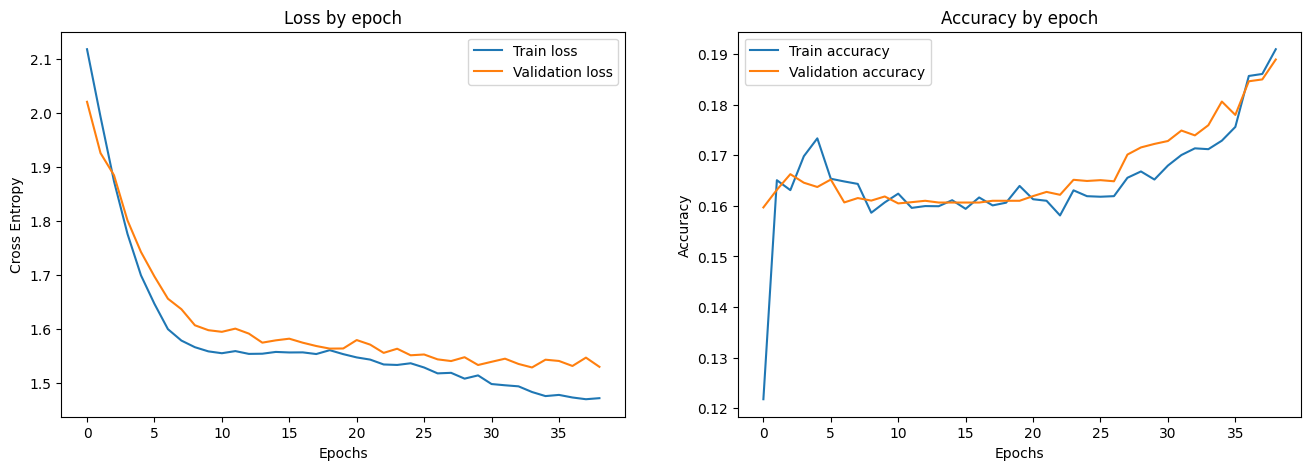

In [29]:
plot_results(
    train_loss_by_epoch,
    valid_loss_by_epoch,
    train_accuracy_by_epoch,
    valid_accuracy_by_epoch)

#### Realizar algunas predicciones

In [30]:
# Se realizan 10 predicciones para cada clase con el modelo y se compara con los
# respectivos valores esperados.
print_predictions(
    resnet50_model,
    test_dataset,
    num_predictions=10,
    device=device)

Normal ==================

El valor esperado es "Normal"
El valor obtenido por el modelo es "Normal"

El valor esperado es "Normal"
El valor obtenido por el modelo es "Normal"

El valor esperado es "Normal"
El valor obtenido por el modelo es "Normal"

El valor esperado es "Normal"
El valor obtenido por el modelo es "Normal"

El valor esperado es "Normal"
El valor obtenido por el modelo es "Normal"

El valor esperado es "Normal"
El valor obtenido por el modelo es "Normal"

El valor esperado es "Normal"
El valor obtenido por el modelo es "Normal"

El valor esperado es "Normal"
El valor obtenido por el modelo es "Normal"

El valor esperado es "Normal"
El valor obtenido por el modelo es "Normal"

El valor esperado es "Normal"
El valor obtenido por el modelo es "Normal"

El valor esperado es "Normal"
El valor obtenido por el modelo es "Normal"

Diabetes ==================

El valor esperado es "Diabetes"
El valor obtenido por el modelo es "Normal"

El valor esperado es "Diabetes"
El valor o